*First compiled: May 1, 2017.*

# DPT for hematopoiesis in mouse [(Moignard *et al.*, 2015)](http://dx.doi.org/10.1038/nbt.3154)

This has been published by [Haghverdi *et al.*, Nat. Meth. (2016)](http://dx.doi.org/10.1038/nmeth.3971) together with a Matlab implementation of Diffusion Pseudotime. The data is from [Moignard *et al.*, Nat. Biotechn. (2015)](http://dx.doi.org/10.1038/nbt.3154).

This is qPCR data.

In [1]:
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
# we will soon provide an update with more recent dependencies
sc.logging.print_versions_dependencies_numerics()

Running Scanpy 0.3.2 on 2017-11-29 23:03.
Dependencies: numpy==1.13.3 scipy==1.0.0 pandas==0.21.0 scikit-learn==0.18.2 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.5.2+274.g35181a7 


This is single-cell qPCR data. It's already on a logrithmic scale and pretty low-dimensional. We do not have to perform extensive preprocessing.

1. Filter out a few genes.
2. Choose a 'root cell'.                                                                                                                                                           
3. Define groupnames by inspecting cellnames.                                                                                                                                    

In [2]:
filename = 'data/moignard15/nbt.3154-S3.xlsx'
# the url is used to download the file if it's not there yet
backup_url = 'http://www.nature.com/nbt/journal/v33/n3/extref/nbt.3154-S3.xlsx'
adata = sc.read(filename, sheet='dCt_values.txt', cache=True, backup_url=backup_url)
# filter out genes as done by Haghverdi et al. (2016)
removed_genes = np.in1d(adata.var_names, ['Eif2b1', 'Mrpl19', 'Polr2a', 'Ubc'])
adata = adata[:, ~removed_genes]  # retain non-removed genes
# choose root cell as in Haghverdi et al. (2016)
adata.uns['iroot'] = 532  # note that in Matlab/R, counting starts at 1
# annotate with Moignard et al. (2015) experimental cell groups
groups_names = ['HF', 'NP', 'PS', '4SG', '4SFG']
# annotate each sample/cell
adata.smp['exp_groups'] = [
    next(gname for gname in groups_names if sname.startswith(gname))
    for sname in adata.smp_names]
# fix the order and colors of names in "groups"
adata.uns['exp_groups_order'] = groups_names
adata.uns['exp_groups_colors'] = ['#D7A83E', '#7AAE5D', '#497ABC', '#AF353A', '#765099']

reading cache ./write/data/moignard15/nbt.3154-S3.h5


Perform a Diffusion Pseudotime analysis.

In [3]:
sc.tl.dpt(adata, n_branchings=1, n_neighbors=5, knn=False)

perform Diffusion Pseudotime analysis
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 5 
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [ 1.0000017881  0.9924937487  0.973900497   0.8865169287  0.8607167006
      0.8255124688  0.7805156112  0.7599624991  0.7338711619  0.7300988436]
    detect 1 branching
    do not consider groups with less than 39 points for splitting
    branching 1: split group 0
finished (0:00:06.289) and added
    "dpt_pseudotime", the pseudotime (adata.smp),
    "dpt_groups", the branching subgroups of dpt (adata.smp)
    "dpt_order", order according to groups and increasing pseudtime (adata.smp)


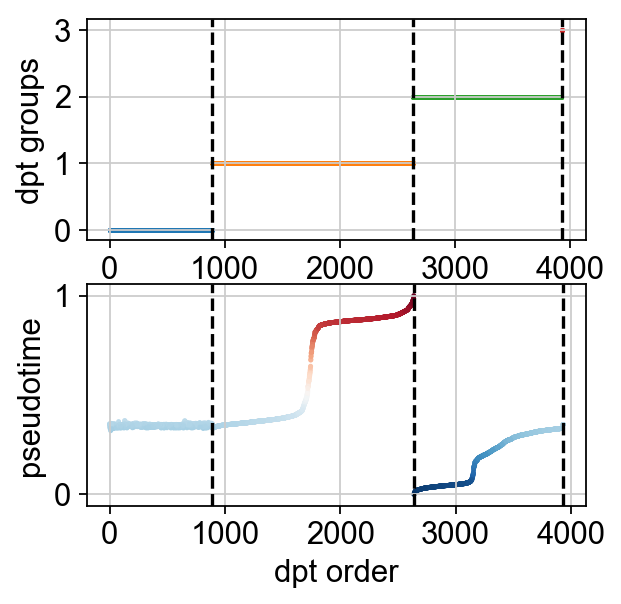

In [4]:
sc.pl.dpt_groups_pseudotime(adata)

... storing exp_groups as categorical type
--> access categories as adata.smp.exp_groups.cat.categories


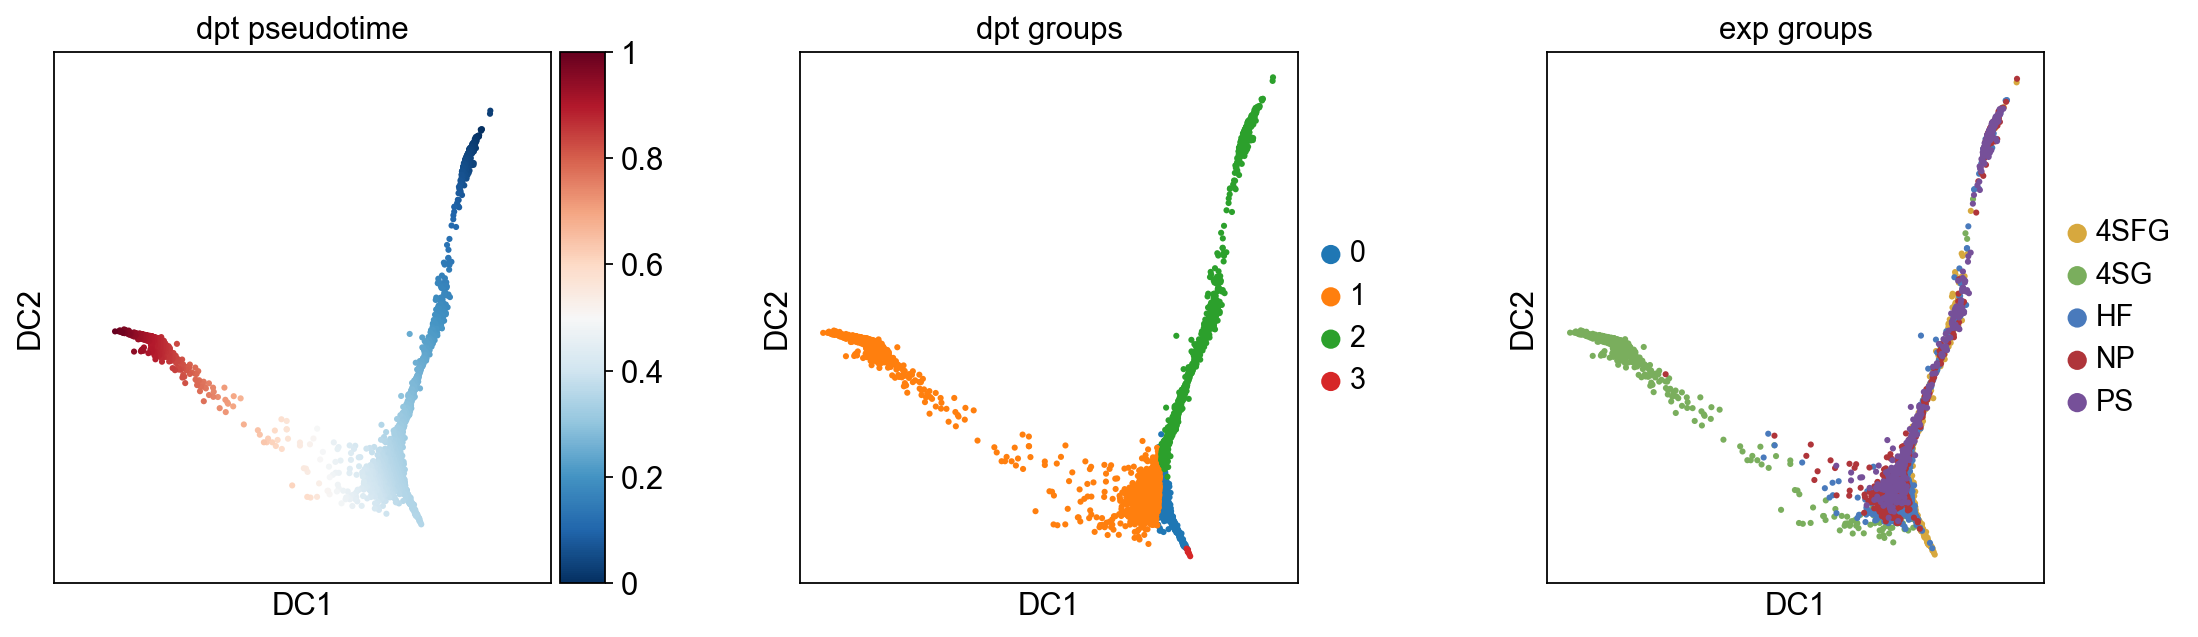

In [5]:
axs = sc.pl.scatter(adata, basis='diffmap',
                    color=['dpt_pseudotime', 'dpt_groups', 'exp_groups'])

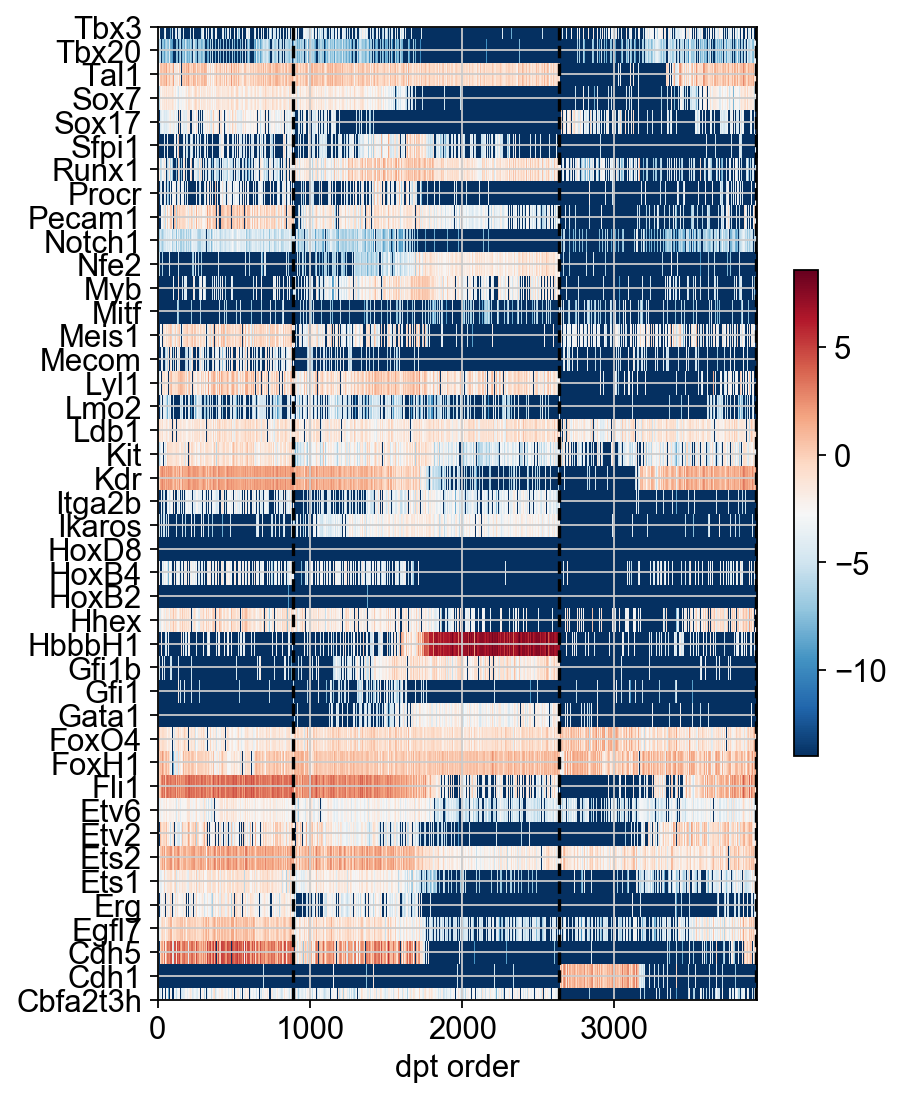

In [6]:
sc.pl.dpt_timeseries(adata)

We can annotate the cell groups as follows.

In [7]:
adata.smp['dpt_groups'].cat.categories = [
    'undecided/endothelial', 'erythrocytes', 'trunk', 'endothelial']

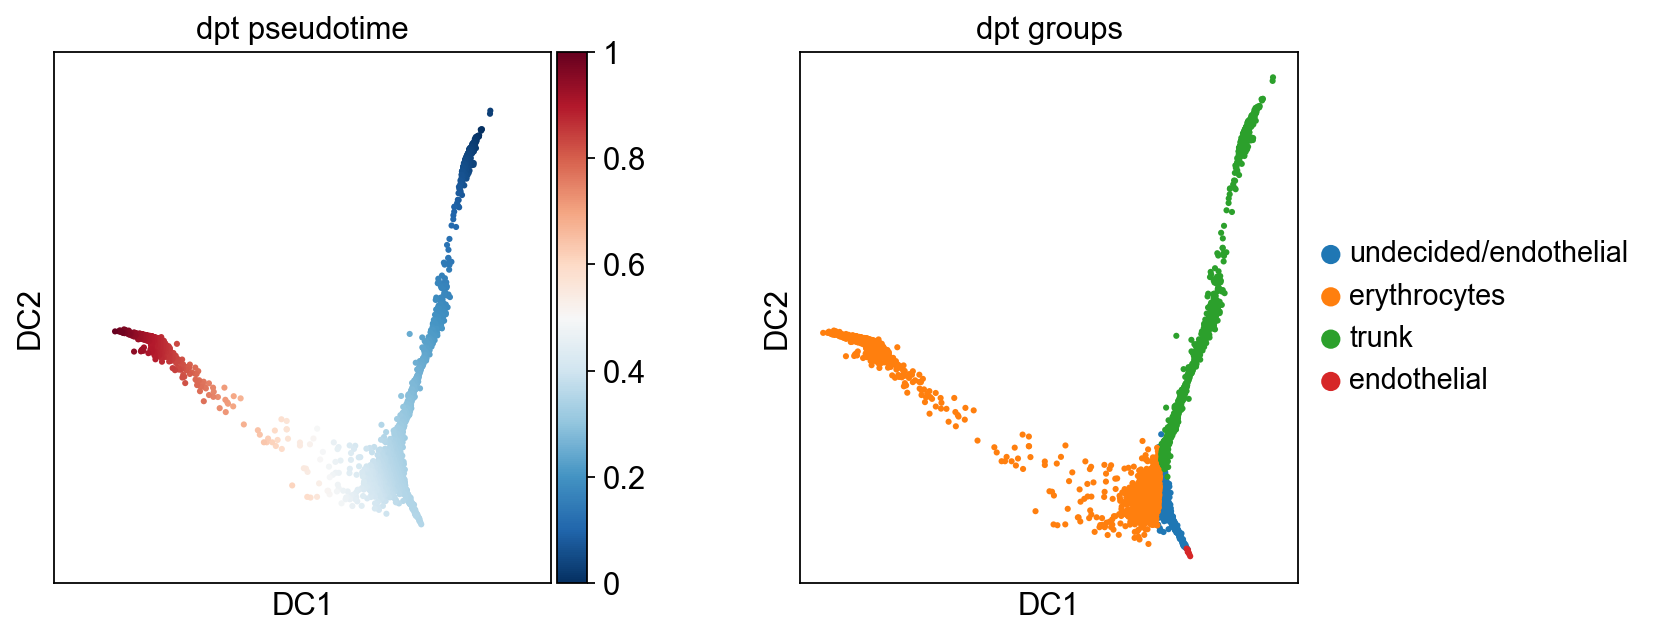

In [8]:
sc.pl.dpt_scatter(adata)

Save the results, for instance, as either as 'hdf5' or 'csv'.

In [9]:
sc.write('moignard15', adata, compression='gzip')

Either like this:

In [10]:
adata.smp.to_csv('./write/annotation.csv')

Or the full object, for instance, like this.

In [11]:
sc.write('./write/moignard15.csv', adata)

writing csv files to ./write/moignard15/
